## Vanishing Gradients

#### In this notebook, we will demonstrate the difference between using sigmoid and ReLU nonlinearities in a simple neural network with two hidden layers. This notebook is built off of a minimal net demo done by Andrej Karpathy for CS 231n, which you can check out here: http://cs231n.github.io/neural-networks-case-study/

In [1]:
# Setup
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

import seaborn as sns
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_style("whitegrid")

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

(-1, 1)

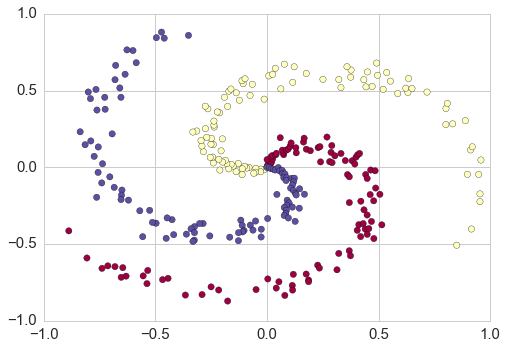

In [2]:
#generate random data -- not linearly separable 
np.random.seed(0)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D))
num_train_examples = X.shape[0]
y = np.zeros(N*K, dtype='uint8')
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim([-1,1])
plt.ylim([-1,1])


The sigmoid function "squashes" inputs to lie between 0 and 1. Unfortunately, this means that for inputs with sigmoid output close to 0 or 1, the gradient with respect to those inputs are close to zero. This leads to the phenomenon of vanishing gradients, where gradients drop close to zero, and the net does not learn well.

On the other hand, the relu function (max(0, x)) does not saturate with input size. Plot these functions to gain intution. 

In [3]:
def sigmoid(x):
    x = 1/(1+np.exp(-x))
    return x

def sigmoid_grad(x):
    return (x)*(1-x)

def relu(x):
    return np.maximum(0,x)

Let's try and see now how the two kinds of nonlinearities change deep neural net training in practice. Below, we build a very simple neural net with three layers (two hidden layers), for which you can swap out ReLU/ sigmoid nonlinearities.

In [4]:
#function to train a three layer neural net with either RELU or sigmoid nonlinearity via vanilla grad descent

def three_layer_net(NONLINEARITY,X,y, model, step_size, reg):
    #parameter initialization
    
    h= model['h']
    h2= model['h2']
    W1= model['W1']
    W2= model['W2']
    W3= model['W3']
    b1= model['b1']
    b2= model['b2']
    b3= model['b3']
    
    
    # some hyperparameters


    # gradient descent loop
    num_examples = X.shape[0]
    plot_array_1=[]
    plot_array_2=[]
    for i in range(50000):

        #FOWARD PROP

        if NONLINEARITY== 'RELU':
            hidden_layer = relu(np.dot(X, W1) + b1)
            hidden_layer2 = relu(np.dot(hidden_layer, W2) + b2)
            scores = np.dot(hidden_layer2, W3) + b3

        elif NONLINEARITY == 'SIGM':
            hidden_layer = sigmoid(np.dot(X, W1) + b1)
            hidden_layer2 = sigmoid(np.dot(hidden_layer, W2) + b2)
            scores = np.dot(hidden_layer2, W3) + b3

        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]

        # compute the loss: average cross-entropy loss and regularization
        corect_logprobs = -np.log(probs[range(num_examples),y])
        data_loss = np.sum(corect_logprobs)/num_examples
        reg_loss = 0.5*reg*np.sum(W1*W1) + 0.5*reg*np.sum(W2*W2)+ 0.5*reg*np.sum(W3*W3)
        loss = data_loss + reg_loss
        if i % 1000 == 0:
            print("iteration %d: loss %f" % (i, loss))


        # compute the gradient on scores
        dscores = probs
        dscores[range(num_examples),y] -= 1
        dscores /= num_examples

 
        # BACKPROP HERE
        dW3 = (hidden_layer2.T).dot(dscores)
        db3 = np.sum(dscores, axis=0, keepdims=True)


        if NONLINEARITY == 'RELU':

            #backprop ReLU nonlinearity here
            dhidden2 = np.dot(dscores, W3.T)
            dhidden2[hidden_layer2 <= 0] = 0
            dW2 =  np.dot( hidden_layer.T, dhidden2)
            plot_array_2.append(np.sum(np.abs(dW2))/np.sum(np.abs(dW2.shape)))
            db2 = np.sum(dhidden2, axis=0)
            dhidden = np.dot(dhidden2, W2.T)
            dhidden[hidden_layer <= 0] = 0
            
        elif NONLINEARITY == 'SIGM':

            #backprop sigmoid nonlinearity here
            dhidden2 = dscores.dot(W3.T)*sigmoid_grad(hidden_layer2)
            dW2 = (hidden_layer.T).dot(dhidden2)
            plot_array_2.append(np.sum(np.abs(dW2))/np.sum(np.abs(dW2.shape)))
            db2 = np.sum(dhidden2, axis=0)
            dhidden = dhidden2.dot(W2.T)*sigmoid_grad(hidden_layer)

        
        dW1 =  np.dot(X.T, dhidden)
        plot_array_1.append(np.sum(np.abs(dW1))/np.sum(np.abs(dW1.shape)))
        db1 = np.sum(dhidden, axis=0)

        # add regularization
        dW3+= reg * W3
        dW2 += reg * W2
        dW1 += reg * W1
        
        #option to return loss, grads -- uncomment next comment
        grads={}
        grads['W1']=dW1
        grads['W2']=dW2
        grads['W3']=dW3
        grads['b1']=db1
        grads['b2']=db2
        grads['b3']=db3
        #return loss, grads
        
        
        # update
        W1 += -step_size * dW1
        b1 += -step_size * db1
        W2 += -step_size * dW2
        b2 += -step_size * db2
        W3 += -step_size * dW3
        b3 += -step_size * db3
    # evaluate training set accuracy
    if NONLINEARITY == 'RELU':
        hidden_layer = relu(np.dot(X, W1) + b1)
        hidden_layer2 = relu(np.dot(hidden_layer, W2) + b2)
    elif NONLINEARITY == 'SIGM':
        hidden_layer = sigmoid(np.dot(X, W1) + b1)
        hidden_layer2 = sigmoid(np.dot(hidden_layer, W2) + b2)
    scores = np.dot(hidden_layer2, W3) + b3
    predicted_class = np.argmax(scores, axis=1)
    print('training accuracy: %.2f' % (np.mean(predicted_class == y)))
    #return cost, grads
    return plot_array_1, plot_array_2, W1, W2, W3, b1, b2, b3

    

#### Train net with sigmoid nonlinearity first

In [5]:
#Initialize toy model, train sigmoid net

N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
h=50
h2=50
num_train_examples = X.shape[0]

model={}
model['h'] = h # size of hidden layer 1
model['h2']= h2# size of hidden layer 2
model['W1']= 0.1 * np.random.randn(D,h)
model['b1'] = np.zeros((1,h))
model['W2'] = 0.1 * np.random.randn(h,h2)
model['b2']= np.zeros((1,h2))
model['W3'] = 0.1 * np.random.randn(h2,K)
model['b3'] = np.zeros((1,K))

(sigm_array_1, sigm_array_2, s_W1, s_W2,s_W3, s_b1, s_b2,s_b3) = three_layer_net('SIGM', X,y,model, step_size=1e-1, reg=1e-3)


iteration 0: loss 1.156405
iteration 1000: loss 1.100737
iteration 2000: loss 0.999698
iteration 3000: loss 0.855495
iteration 4000: loss 0.819427
iteration 5000: loss 0.814825
iteration 6000: loss 0.810526
iteration 7000: loss 0.805943
iteration 8000: loss 0.800688
iteration 9000: loss 0.793976
iteration 10000: loss 0.783201
iteration 11000: loss 0.759909
iteration 12000: loss 0.719792
iteration 13000: loss 0.683194
iteration 14000: loss 0.655847
iteration 15000: loss 0.634996
iteration 16000: loss 0.618527
iteration 17000: loss 0.602246
iteration 18000: loss 0.579710
iteration 19000: loss 0.546264
iteration 20000: loss 0.512831
iteration 21000: loss 0.492403
iteration 22000: loss 0.481854
iteration 23000: loss 0.475923
iteration 24000: loss 0.472031
iteration 25000: loss 0.469086
iteration 26000: loss 0.466611
iteration 27000: loss 0.464386
iteration 28000: loss 0.462306
iteration 29000: loss 0.460319
iteration 30000: loss 0.458398
iteration 31000: loss 0.456528
iteration 32000: loss

#### Now train net with ReLU nonlinearity 

In [6]:
#Re-initialize model, train relu net

model={}
model['h'] = h # size of hidden layer 1
model['h2']= h2# size of hidden layer 2
model['W1']= 0.1 * np.random.randn(D,h)
model['b1'] = np.zeros((1,h))
model['W2'] = 0.1 * np.random.randn(h,h2)
model['b2']= np.zeros((1,h2))
model['W3'] = 0.1 * np.random.randn(h2,K)
model['b3'] = np.zeros((1,K))

(relu_array_1, relu_array_2, r_W1, r_W2,r_W3, r_b1, r_b2,r_b3) = three_layer_net('RELU', X,y,model, step_size=1e-1, reg=1e-3)


iteration 0: loss 1.116188
iteration 1000: loss 0.275047
iteration 2000: loss 0.152297
iteration 3000: loss 0.136370
iteration 4000: loss 0.130853
iteration 5000: loss 0.127878
iteration 6000: loss 0.125951
iteration 7000: loss 0.124599
iteration 8000: loss 0.123502
iteration 9000: loss 0.122594
iteration 10000: loss 0.121833
iteration 11000: loss 0.121202
iteration 12000: loss 0.120650
iteration 13000: loss 0.120165
iteration 14000: loss 0.119734
iteration 15000: loss 0.119345
iteration 16000: loss 0.119000
iteration 17000: loss 0.118696
iteration 18000: loss 0.118423
iteration 19000: loss 0.118166
iteration 20000: loss 0.117932
iteration 21000: loss 0.117718
iteration 22000: loss 0.117521
iteration 23000: loss 0.117337
iteration 24000: loss 0.117168
iteration 25000: loss 0.117011
iteration 26000: loss 0.116863
iteration 27000: loss 0.116721
iteration 28000: loss 0.116574
iteration 29000: loss 0.116427
iteration 30000: loss 0.116293
iteration 31000: loss 0.116164
iteration 32000: loss

# The Vanishing Gradient Issue

We can use the sum of the magnitude of gradients for the weights between hidden layers as a cheap heuristic to measure speed of learning (you can also use the magnitude of gradients for each neuron in the hidden layer here). Intuitevely, when the magnitude of the gradients of the weight vectors or of each neuron are large, the net is learning faster. (NOTE: For our net, each hidden layer has the same number of neurons. If you want to play around with this, make sure to adjust the heuristic to account for the number of neurons in the layer). 

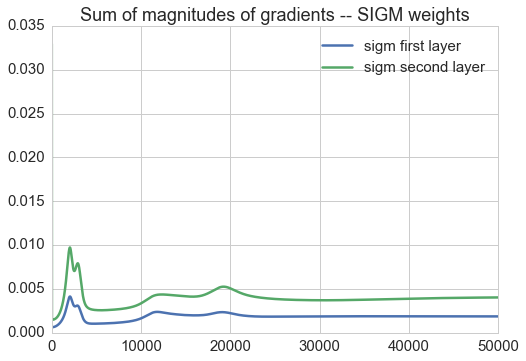

In [7]:

plt.plot(np.array(sigm_array_1))
plt.plot(np.array(sigm_array_2))
plt.title('Sum of magnitudes of gradients -- SIGM weights')
plt.legend(("sigm first layer", "sigm second layer"))

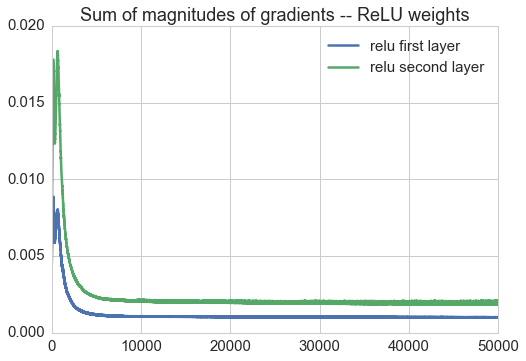

In [8]:
plt.plot(np.array(relu_array_1))
plt.plot(np.array(relu_array_2))
plt.title('Sum of magnitudes of gradients -- ReLU weights')
plt.legend(("relu first layer", "relu second layer"))

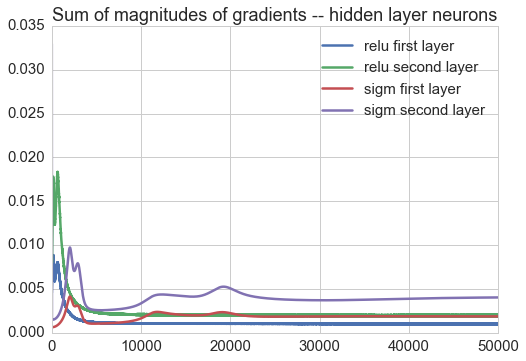

In [9]:
# Overlaying the two plots to compare
plt.plot(np.array(relu_array_1))
plt.plot(np.array(relu_array_2))
plt.plot(np.array(sigm_array_1))
plt.plot(np.array(sigm_array_2))
plt.title('Sum of magnitudes of gradients -- hidden layer neurons')
plt.legend(("relu first layer", "relu second layer","sigm first layer", "sigm second layer"))

#### Feel free to play around with this notebook to gain intuition. Things you might want to try:

- Adding additional layers to the nets and seeing how early layers continue to train slowly for the sigmoid net 
- Experiment with hyperparameter tuning for the nets -- changing regularization and gradient descent step size
- Experiment with different nonlinearities -- Leaky ReLU, Maxout. How quickly do different layers learn now?



We can see how well each classifier does in terms of distinguishing the toy data classes. As expected, since the ReLU net trains faster, for a set number of epochs it performs better compared to the sigmoid net. 

(-1.8712034092398278, 1.8687965907601756)

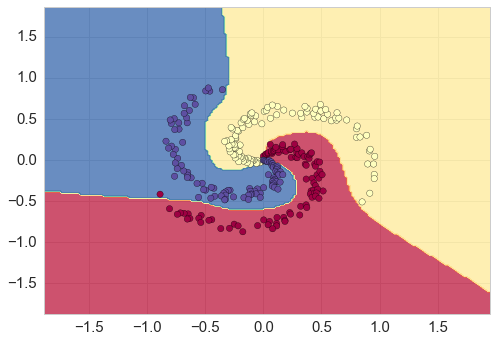

In [10]:
# plot the classifiers- SIGMOID
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(sigmoid(np.dot(sigmoid(np.dot(np.c_[xx.ravel(), yy.ravel()], s_W1) + s_b1), s_W2) + s_b2), s_W3) + s_b3
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())


(-1.8712034092398278, 1.8687965907601756)

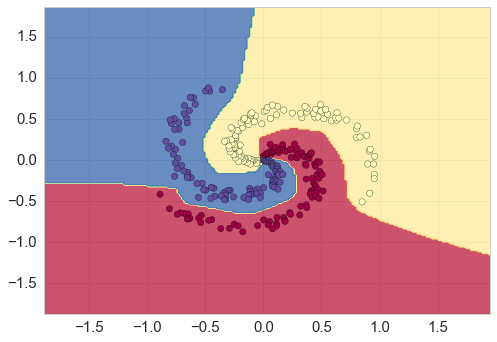

In [11]:
# plot the classifiers-- RELU
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(relu(np.dot(relu(np.dot(np.c_[xx.ravel(), yy.ravel()], r_W1) + r_b1), r_W2) + r_b2), r_W3) + r_b3
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
